## Importing Libraries

In [2]:
import requests
import zipfile
from pathlib import Path
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision

In [3]:
from pathlib import Path
import requests, zipfile, os

folder = Path('resources')
image_path = folder / 'data'

if image_path.is_dir():
    print(f"{image_path} already exists")
else:
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download the file
    url = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip"
    response = requests.get(url)

    zip_file_path = image_path / 'concrete_crack_images_for_classification.zip'
    with open(zip_file_path, 'wb') as f:
        print("Downloading the file")
        f.write(response.content)

    # Confirm download
    print(f"Downloaded size: {zip_file_path.stat().st_size / 1024:.2f} KB")

    # Unzip it
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        print("Unzipping the file")
        zip_ref.extractall(image_path)

    os.remove(zip_file_path)


resources/data already exists


In [4]:
for dir_paths, dir_files, file_names in os.walk(image_path):
    print(f" There are {len(dir_files)} directories and {len(file_names)} images in {dir_paths}")

 There are 2 directories and 1 images in resources/data
 There are 0 directories and 20000 images in resources/data/Positive
 There are 0 directories and 20000 images in resources/data/Negative


Positive folder contains images which doesn't have any kinds of cracks and negative has the vice versa files. 

In [5]:
crack_positive_path = image_path/'positive'
crack_negative_path = image_path/'negative'

In [6]:
crack_negative_path,crack_positive_path

(PosixPath('resources/data/negative'), PosixPath('resources/data/positive'))

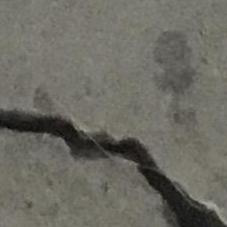

In [7]:
# Plot some random images from positive folders
import random
positive_image_list = list(Path(crack_positive_path).glob('*.jpg'))

rand_postive_img = random.choice(positive_image_list)

img = Image.open(rand_postive_img)

Path(rand_postive_img).parent.stem
img

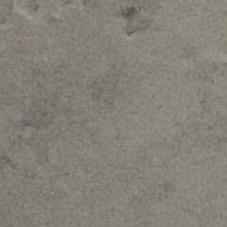

In [8]:
# Plot some random image from negative folders

negative_image_list = list(Path(crack_negative_path).glob('*.jpg'))

rand_negative_img = random.choice(negative_image_list)

img = Image.open(rand_negative_img)

img


<Figure size 3000x1500 with 0 Axes>

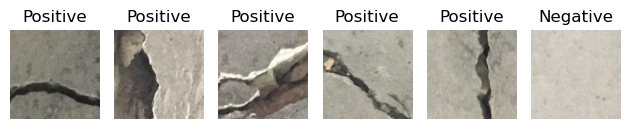

In [9]:
# Plot images with matplotlib
import numpy as np
image_list = list(Path(image_path).glob('*/*.jpg'))

rand_imgs = random.sample(image_list,k = 6)

plt.figure(figsize = (30,15))
plt.subplots(nrows = 1, ncols = 6)
for idx,img in enumerate(rand_imgs):
    
    # set the subplot
    plt.subplot(1,6,idx+1)
    # convert the image into numpy
    np_img = np.asarray(Image.open(img))
    plt.imshow(np_img)
    plt.title(f"{Path(img).parent.stem}")
    plt.axis(False)
    plt.tight_layout()
    
    

In [10]:
len(image_list)

40000

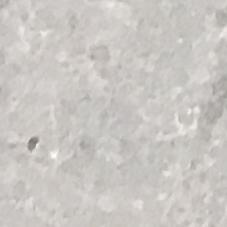

In [11]:
Image.open(image_list[20000])

In [12]:
from torch.utils.data import DataLoader,Dataset

In [13]:
from torchvision import datasets,transforms

In [14]:
# Create transformation funciton
transform_data = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

In [15]:
train_data = datasets.ImageFolder(image_path,
                                 transform = transform_data
                                 )

In [16]:
class_names = train_data.classes

In [17]:
train_data.class_to_idx

{'Negative': 0, 'Positive': 1}

In [18]:
img,label = train_data[20000]
img.shape,label

(torch.Size([3, 64, 64]), 1)

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

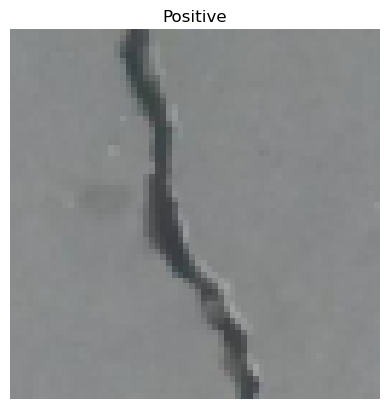

In [19]:
# Plot a random image from the train data
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [20]:
type(train_data)

torchvision.datasets.folder.ImageFolder

In [21]:
shuffled_dataset = list(train_data)

random.shuffle(shuffled_dataset)

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

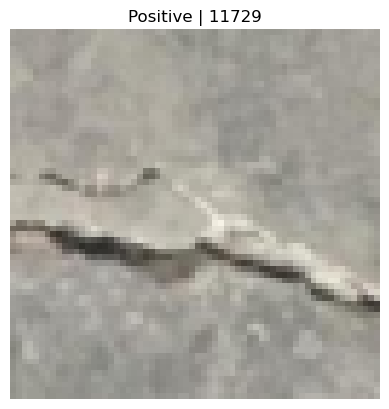

In [22]:
# Plot a random image from the train data
idx = random.randint(0,len(shuffled_dataset))
img,label = shuffled_dataset[idx]
plt.imshow(img.permute(1,2,0))
plt.title(f"{class_names[label]} | {idx}")
plt.axis(False)

## Custom Dataset

In [23]:
def find_classes(img_dir):
    classes = sorted(entry.name for entry in os.scandir(img_dir) if entry.is_dir())

    class_to_idx = {class_name: i for i,class_name in enumerate(classes)}

    return classes,class_to_idx
    

In [24]:
import pathlib
from pathlib import Path

In [48]:
class CustomDataset(Dataset):

    def __init__(self,
                 all_images,
                 transform:torchvision.transforms = None):

        # I got the full sorted path, have to create a list, shuffling that
        self.all_images = all_images
        self.images_list  = list(pathlib.Path(self.all_images).glob("*/*.jpg"))
        random.shuffle(self.images_list)
        self.transform = transform
        self.classes,self.class_to_idx = find_classes(self.all_images)


    def load_img(self,idx):
        img = Image.open(self.images_list[idx])
        return img

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self,idx):
        img = self.load_img(idx)
        class_name = self.images_list[idx].parent.name
        class_to_idx = self.class_to_idx[class_name]
        
        if self.transform:
            img = self.transform(img)

        return img,class_to_idx
        
        

In [26]:
image_path

PosixPath('resources/data')

In [49]:
custom_data = CustomDataset(image_path)

In [28]:
custom_data.classes

['Negative', 'Positive']

In [29]:
custom_data.class_to_idx

{'Negative': 0, 'Positive': 1}

(np.float64(-0.5), np.float64(226.5), np.float64(226.5), np.float64(-0.5))

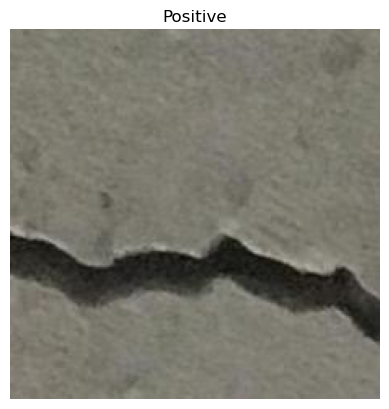

In [51]:
img,label = custom_data[710]
plt.imshow(img)
plt.title(class_names[label])
plt.axis(False)

In [54]:
print(img.size)

(227, 227)


## Split into Train and Validation Dataset